<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/CNN_Eric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import math
from sklearn.metrics import confusion_matrix
from seaborn import heatmap
from sklearn.utils import class_weight

In [2]:
%load_ext tensorboard
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/data/train.npz')['bands']
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/data/train.npz')['lulc']

x_test = np.load('/content/drive/MyDrive/Colab Notebooks/data/public_test.npz')['bands']

In [5]:
x_train_no_data_removed = x_train[y_train != 0, :, :, :, :]
y_train_no_data_removed = y_train[y_train != 0]

In [6]:
x_train_only_no_data = x_train[y_train == 0, :, :, :, :]
y_train_only_no_data = y_train[y_train == 0]

In [7]:
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [8]:
np.histogram(y_train, bins=list(range(len(classes))))[0] / y_train.shape[0] * 100

array([13.08,  2.38, 57.96, 11.25,  7.7 ,  0.58,  0.  ,  0.  ,  2.17,
        4.88])

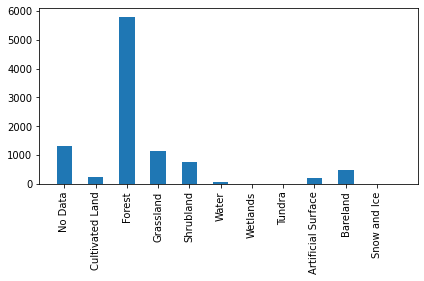

In [9]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [10]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(12,33,33,6)))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
model.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Conv3D(64, kernel_size=(1, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2)))
model.add(tf.keras.layers.BatchNormalization(center=True, scale=True))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(tf.keras.layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 12, 31, 31, 64)    3520      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 15, 15, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 15, 15, 64)    256       
_________________________________________________________________
dropout (Dropout)            (None, 12, 15, 15, 64)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 12, 13, 13, 64)    36928     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 12, 6, 6, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 6, 6, 64)      2

In [11]:
# train model with labelled data only
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train_no_data_removed, y_train_no_data_removed, epochs=10, batch_size=64, validation_split=0.2, callbacks=[tensorboard_callback])

Epoch 1/10
109/109 [==============================] - 42s 95ms/step - loss: 1.4412 - accuracy: 0.7055 - val_loss: 3.7719 - val_accuracy: 0.6136
Epoch 2/10
109/109 [==============================] - 8s 74ms/step - loss: 0.6924 - accuracy: 0.7846 - val_loss: 3.0259 - val_accuracy: 0.5934
Epoch 3/10
109/109 [==============================] - 8s 75ms/step - loss: 0.5680 - accuracy: 0.8100 - val_loss: 3.5593 - val_accuracy: 0.5934
Epoch 4/10
109/109 [==============================] - 8s 75ms/step - loss: 0.4576 - accuracy: 0.8447 - val_loss: 2.8134 - val_accuracy: 0.5969
Epoch 5/10
109/109 [==============================] - 8s 75ms/step - loss: 0.3738 - accuracy: 0.8720 - val_loss: 1.3807 - val_accuracy: 0.6360
Epoch 6/10
109/109 [==============================] - 9s 81ms/step - loss: 0.2851 - accuracy: 0.9022 - val_loss: 1.1100 - val_accuracy: 0.6740
Epoch 7/10
109/109 [==============================] - 8s 75ms/step - loss: 0.1922 - accuracy: 0.9360 - val_loss: 1.4912 - val_accuracy: 0.576

In [12]:
# save model
model.save('model')
#model = tf.keras.models.load_model('model')

INFO:tensorflow:Assets written to: model/assets


In [13]:
# predict the labels for unlabelled data
preds_only_no_data = model.predict(x_train_only_no_data)
# extract the classes
preds_only_no_data_classes = preds_only_no_data.argmax(axis=1)
# replace no data label with predicted labels from the model
y_train[y_train == 0] = preds_only_no_data_classes

In [24]:
np.histogram(y_train, bins=list(range(len(classes))))[0] / y_train.shape[0] * 100

array([ 0.  ,  2.67, 67.97, 11.69,  8.72,  0.67,  0.  ,  0.  ,  2.83,
        5.45])

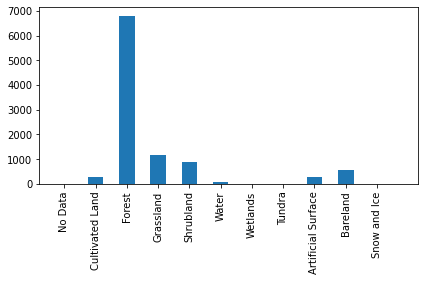

In [23]:
plt.hist(y_train, bins=list(range(len(classes) + 1)), width=0.5, align='mid')
plt.xticks(ticks=[i + 0.25 for i in range(len(classes))], labels=classes, rotation=90)
plt.tight_layout()
plt.show()

In [61]:
# add lower sampling weights for forest label due to imbalanced classes
sample_weights = np.ones(shape=(len(y_train),))
sample_weights[y_train == 2] = 0.4

In [68]:
# balance out classes by use of util function
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)
#class_weight_dict = dict(enumerate(class_weights))
#class_weight_dict[7] = 0
#class_weight_dict[8] = 0
#class_weight_dict

class_weight_dict = {
    0: 0,
    1: class_weights[0],
    2: class_weights[1] + 2,
    3: class_weights[2] + 3,
    4: class_weights[3] + 3,
    5: class_weights[4] - 15,
    6: 0,
    7: 0,
    8: class_weights[5],
    9: class_weights[6],
    10: 0
}
class_weight_dict

[ 5.35045479  0.21017676  1.2220457   1.63826999 21.32196162  5.04795558
  2.62123198]


{0: 0,
 1: 5.350454788657036,
 2: 2.210176758654028,
 3: 4.222045704509348,
 4: 4.638269986893841,
 5: 6.321961620469082,
 6: 0,
 7: 0,
 8: 5.047955577990914,
 9: 2.6212319790301444,
 10: 0}

In [69]:
# train full model
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[tensorboard_callback], class_weight=class_weight_dict, sample_weight=sample_weights)

Epoch 1/10
125/125 [==============================] - 11s 85ms/step - loss: 0.1469 - accuracy: 0.9839 - val_loss: 1.8361 - val_accuracy: 0.7165
Epoch 2/10
125/125 [==============================] - 10s 81ms/step - loss: 0.2252 - accuracy: 0.9732 - val_loss: 3.0325 - val_accuracy: 0.6690
Epoch 3/10
125/125 [==============================] - 10s 82ms/step - loss: 0.1959 - accuracy: 0.9780 - val_loss: 1.8467 - val_accuracy: 0.6935
Epoch 4/10
125/125 [==============================] - 10s 79ms/step - loss: 0.1151 - accuracy: 0.9855 - val_loss: 2.0905 - val_accuracy: 0.7410
Epoch 5/10
125/125 [==============================] - 10s 78ms/step - loss: 0.0938 - accuracy: 0.9883 - val_loss: 2.0909 - val_accuracy: 0.7345
Epoch 6/10
125/125 [==============================] - 10s 82ms/step - loss: 0.0476 - accuracy: 0.9931 - val_loss: 1.9450 - val_accuracy: 0.7415
Epoch 7/10
125/125 [==============================] - 10s 82ms/step - loss: 0.0757 - accuracy: 0.9937 - val_loss: 3.7946 - val_accuracy:

In [22]:
#%tensorboard --logdir logs/fit

In [70]:
# predict labels
preds = model.predict(x_train)
# extract classes
preds_classes = preds.argmax(axis=1)

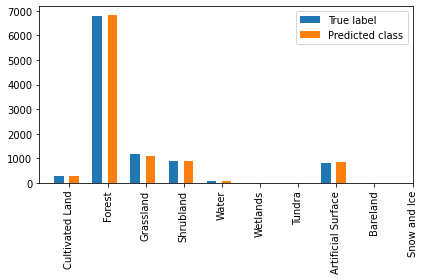

In [71]:
plt.hist([y_train, preds_classes], bins=range(1, len(classes[1:])), width=0.25, align='mid')
plt.xticks(ticks=[i + 1.5 for i in range(len(classes[1:]))], labels=classes[1:], rotation=90)
plt.legend(['True label', 'Predicted class'])
plt.tight_layout()
plt.show()

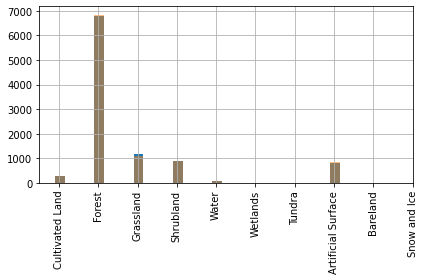

In [72]:
# histogram of preds vs true labels
preds_df = pd.DataFrame({'true':y_train, 'preds':preds_classes})

preds_df['true'].hist(bins=range(1, len(classes[1:])), width=0.25, align='mid')
preds_df['preds'].hist(bins=range(1, len(classes[1:])), width=0.25, align='mid', alpha=0.5)
plt.xticks(ticks=[i + 1.1 for i in range(len(classes[1:]))], labels=classes[1:], rotation=90)
plt.tight_layout()
plt.show()

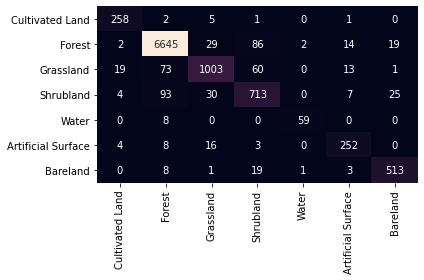

In [73]:
# confusion matrix
conf_df = pd.DataFrame(confusion_matrix(preds_df['true'], preds_df['preds']), index=classes[np.unique(preds_classes)], columns=classes[np.unique(preds_classes)])
heatmap(conf_df, annot=True, fmt='d', cbar=False)
plt.tight_layout()
plt.show()

In [20]:
# extract single test image
img = x_test[3, :, :, :]
# window dimensions
x, y = 33, 33
# prediction matrix
pred = np.zeros((img.shape[0], img.shape[1]))
# all subwindows
windows = []

# iterate over all rows and columns of the test image
for i in range(img.shape[0]):
  for j in range(img.shape[1]):
    # calculate window bounds
    left, right, top, bottom = math.floor(i - x/2), math.floor(i + x/2), math.floor(j - y/2), math.floor(j + y/2)
    # check out of bounds
    if not (left < 0 or right > img.shape[0] or top < 0 or bottom > img.shape[1]):
      # takes forever
      #pred[i, j] = model.predict(np.array([x_test[:, left:right, top:bottom, :]])).argmax(1)[0]
      pred[i, j] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


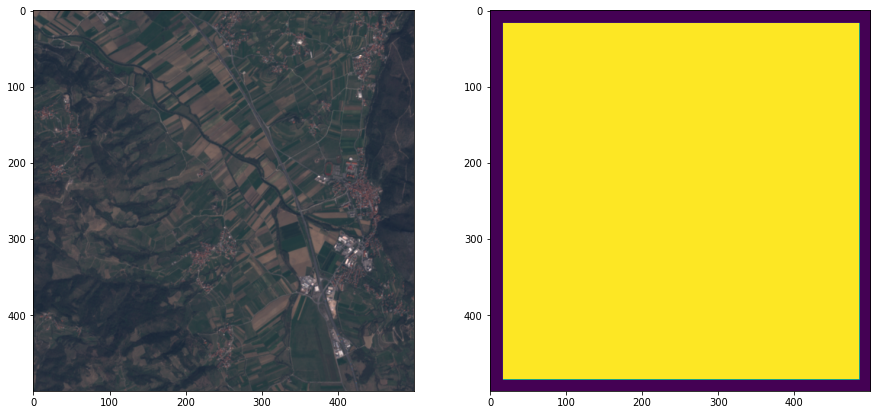

In [21]:
# plot image and predicted labels
month = 3

f, (sat, lulc) = plt.subplots(1, 2, figsize=(15,15))

band = 0.5 + 2.5 * (np.flip(x_test[month, :, :, :3], -1) + .3 - 0.5)
sat.imshow(band, cmap='gray')

lulc.imshow(pred)

plt.show()